# Clean and Explore the Data

**FIX: Give it an index, record the index before, record the index after, the ones that are missing need to get added with some mathematical function. **

The data scraped from RateMyTeacher.com contains more than just reviews. We have factual information about schools and teachers along with review scores. The resulting review corpus is massive so the language modeling analysis will likely benefit from exploring different parts of the corpus separately to see how contexts and topics change.  

In [1]:
import pandas as pd
import numpy as np
import difflib
import os 
import re 
import zipfile
import matplotlib.pyplot as plt 
import seaborn as sns
import bear_necessities as bn
import warnings
warnings.filterwarnings('ignore')

## Importing Data

We begin by importing the files we're interested in (in this case all of the ratemyteacher data for the US and some suplementary data from NCES). 

### RMT Text & Summary Stats

First we want to separate out the suplmentary information from the text in the RMT data. We pickle the summary data for easy and quick use and compress and pickle the text data so it can be used later in a language analysis. 

In [2]:
%%time

# Select all and press "Ctrl + /" to uncomment. Only run if the data is updated or missing

# get the US rmt data files from the data folder (you may need to unzip the files from us_state_city_rmt.zip or you can use the zipfile module to read it directly)
files = [f for f in list(os.walk(os.getcwd() + '/data'))[0][2] if 'US' in f]

docs = []
data = pd.DataFrame() 

for f in files: 
    # read in the file 
    df = bn.loosen(os.getcwd() + '/data/' + f)
    
    # sometimes the website lists reviews where there are none and an empty file gets saved
    if len(df) == 0: # if we've loaded one of these empty files 
        continue # move on to the next

    # remove missing values 
    df = df[[type(row['Text'])!=float for idx, row in df.iterrows()]]
        
    for doc in list(df['Text'].values):
        docs.append(doc)

    # if there was an unnames column (usually the index) we erase it 
    df = df.drop([c for c in df.columns if 'Unnamed' in c], 1)
    # we don't want the text but we want an idea, so we take the length 
    df['Review_Length'] = df['Text'].apply(lambda x: len(str(x)))
    # we drop the text but in this case since the data is saved by city we drop "State" and "City" and only save the filename
    df = df.drop(['Text','State','City'], 1)
    # we will be able to trace back specific reviews based on their file and index 
    df['File'] = str(f)
    df = df.reset_index().rename(columns = {'index':'FID'})
    
    # and append it to the main dataset 
    data = data.append(df, ignore_index = True, sort = False)

# we pickle the data so it can be loaded very quickly 
bn.compressed_pickle(os.getcwd() + '/data/review_stats', data)
    
# we pickle and compress the text data
bn.compressed_pickle(os.getcwd() + '/data/full_review_text', docs)

Wall time: 1h 12min 23s


## Split Data By Ratings

Now we want to compartmentalize the data into distinct ranges of ratings. Our goal is to acheive a fairly uniform group size for each range. You will notice that the highest rated comments outweight everything else significantly, a first brief insight into the distribution of teacher quality.

In [2]:
# import the data if need be
data = bn.decompress_pickle(os.getcwd() + '/data/review_stats.pbz2')

In [3]:
# normalize the ratings to fall in [0,100]
data['Rating'] = (data['Rating']/data['Rating'].max()) * 100

# we bin the data by ratings such that we end up with a similar number of rows in each rating bin 
rating_bins = [0, 35, 60, 65, 75, 85, 95, 101]

# split the ratings data into the bins above and place it in the Range field 
data['Range'] = pd.cut(data['Rating'], rating_bins, right = False)
range_dist = data['Range'].value_counts()

# find the indices for each rating bin
range_indices = {} 
for v in range_dist.keys():
    range_indices[str(v)] = list(data.loc[data['Range']==v].index)
    
# and save the dictionary with the indices
bn.full_pickle(os.getcwd() + '/data/by_rating_range', range_indices)

range_dist.sort_index()

[0, 35)       359387
[35, 60)      309850
[60, 65)      244504
[65, 75)      248963
[75, 85)      404741
[85, 95)      593581
[95, 101)    2702952
Name: Range, dtype: int64

## Experimental Parameters - Cleaning Configurations 

The methods we use for cleaning data are important in two ways. The first is the models they allow us to use. For example, Facebook's FastText has its own phrase generator and can benefit from stop-words so we might want to try it with a relatively raw version of the text. Alternatively, keeping certain stop words can have a significant on the sentiment of a sentence. 

In this section we create a different cleaning configurations which we will use to experiment with later on. 

In [69]:
data_configurations = {} 
# first configuration - total cleaning 
data_configurations['A1']={}
data_configurations['A1']['lemmatizer']=True
data_configurations['A1']['stemmer']=True
data_configurations['A1']['remove_stops']=True
data_configurations['A1']['no_not']=None
data_configurations['A1']['remove_contractions']=True
data_configurations['A1']['repeated_removal']=2
data_configurations['A1']['gram']=4
data_configurations['A1']['pthresh']=50
data_configurations['A1']['spell_check']=False

# second configuration - light cleaning (mainly for FastText)
data_configurations['B1']={}
data_configurations['B1']['lemmatizer']=False
data_configurations['B1']['stemmer']=False
data_configurations['B1']['remove_stops']=False
data_configurations['B1']['no_not']=None
data_configurations['B1']['remove_contractions']=True
data_configurations['B1']['repeated_removal']=None # fasttext interprets words as character n-grams so reductions may not be helpful
data_configurations['B1']['gram']=None
data_configurations['B1']['pthresh']=50 # irrelevant here becuase phrase finder is turned off
data_configurations['B1']['spell_check']=False

# third configuration - fasttext cleaning (mainly for FastText)
data_configurations['C1']={}
data_configurations['C1']['lemmatizer']=True
data_configurations['C1']['stemmer']=True
data_configurations['C1']['remove_stops']=False
data_configurations['C1']['no_not']=None
data_configurations['C1']['remove_contractions']=True
data_configurations['C1']['repeated_removal']=None # fasttext interprets words as character n-grams so reductions may not be helpful
data_configurations['C1']['gram']=None
data_configurations['C1']['pthresh']=50 # irrelevant here because phrase finder is turned off 
data_configurations['C1']['spell_check']=False

# fourth configuration - general cleaning without stemming and with exceptions 
data_configurations['E1']={}
data_configurations['E1']['lemmatizer']=True
data_configurations['E1']['stemmer']=False
data_configurations['E1']['remove_stops']=True
data_configurations['E1']['no_not']=['not','off','on']
data_configurations['E1']['remove_contractions']=True
data_configurations['E1']['repeated_removal']=2
data_configurations['E1']['gram']=5
data_configurations['E1']['pthresh']=50
data_configurations['E1']['spell_check']=False

## Cleaning the Data 

Now we will begin cleaning the data by range for each of the configurations submitted. We will save the cleaned data into compressed pickle files which can reduce file sizes by several times. 

In [79]:
import modeling_tools_v2 as mt 
from importlib import reload
import time 
# during dev, reloads the mt script to update changes
mt = reload(mt)

for config in data_configurations:
    # track time 
    st = time.time()
    
    # we load the full corpus of review texts everytime we loop through a configuration 
    # this adds time but saves memory by avoiding having to make a copy each time we loop
    text = bn.decompress_pickle(os.getcwd() + '/data/full_review_text.pbz2')
    
    # track corpus length 
    cl1 = len(text)

    # returns a tuple (cleaned documents, stem map, lemma map, phrase frequencies)
    cleaned =mt.pre_process(text,
                            lemmatizer=data_configurations[config]['lemmatizer'],
                            stemmer=data_configurations[config]['stemmer'],
                            remove_stops=data_configurations[config]['remove_stops'],
                            no_not=data_configurations[config]['no_not'], 
                            remove_contractions=data_configurations[config]['remove_contractions'],
                            repeated_removal=data_configurations[config]['repeated_removal'],
                            gram=data_configurations[config]['gram'],
                            pthresh=data_configurations[config]['pthresh'],
                            spell_check=data_configurations[config]['spell_check']
                            )

    # track corpus length 
    cl2 = len(cleaned[0])
    # record the corpus lengths
    data_configurations[config]['length_prior'] = cl1
    data_configurations[config]['length_post'] = cl2
    
    # record the duration of the cleaning process
    data_configurations[config]['duration'] = time.time()-st
        
    bn.compressed_pickle(os.getcwd() + '/data/cleaned_data/cleaned_docs_'+str(config), cleaned)

In [80]:
experimental_setup = pd.DataFrame(data_configurations)
experimental_setup.to_csv(os.getcwd()+'/documents/cleaning_parameters.csv')
experimental_setup

,A1,B1,C1,E1
duration,6930.11,3096.36,6650.57,6146.23
gram,4,None,None,5
lemmatizer,True,False,True,True
length_post,4863978,4863978,4863978,4863978
length_prior,4863978,4863978,4863978,4863978
no_not,None,None,None,"[not, off, on]"
pthresh,50,50,50,50
remove_contractions,True,True,True,True
remove_stops,True,False,False,True
repeated_removal,2,None,None,2


## Creating Labels for Supervised Learning 

In this last part of the notebook we will create labels for the data based on other lakert scale information that the reviewers submitted and explore some more summary statistics. We begin by doing some basic analysis. 

### Exploring the Data

As we can see from the above binned distribution , the sample is heavily skewed towards positive reviews. If we take subsamples of the data such that we only keep teachers who received at least 'n' reviews, we see that this distribution holds. 

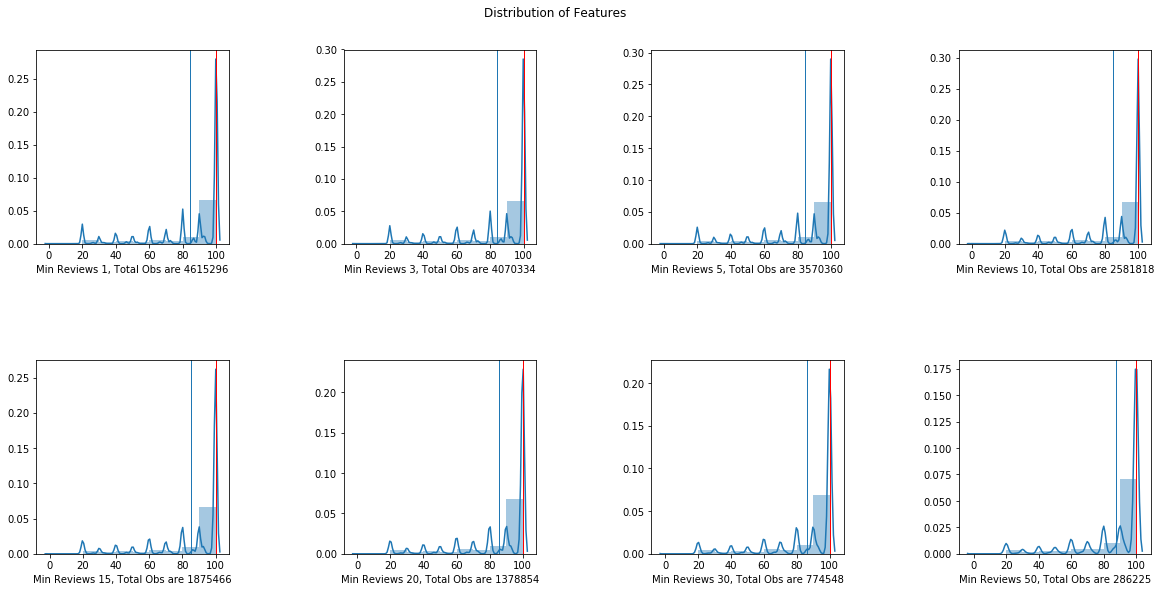

In [5]:
plt.rcParams['axes.facecolor']= 'white'
plt.rcParams['figure.facecolor']= 'white'

# create a column containing the number of reviews a given teacher recieved
data['num_reviews'] = data.groupby('Teacher')['FID'].transform('count')

# we will also bin these differently for the histograms
bins = list(range(0,101,10))

# list of the minimum number of reviews 
min_num_reviews = [1,3,5,10,15,20,30,50]

plot_num = 8
fig, axes = plt.subplots(2, 4)
plt.subplots_adjust(wspace=0.6, hspace=0.6, left=0.1, bottom=0.22, right=0.96, top=0.92)
axes = axes.flatten()
fig.set_size_inches(18, 10)
fig.suptitle('Distribution of Features')

for i,n in enumerate(min_num_reviews):        
    lbl = 'Min Reviews %d, Total Obs are %d' % (n, (len(data.loc[data['num_reviews']>n])))
    sns.distplot(data.loc[data['num_reviews']>n,'Rating'], bins = bins, axlabel=lbl, ax=axes[i])
    axes[i].axvline(data.loc[data['num_reviews']>n,'Rating'].mean(),linewidth=1)
    axes[i].axvline(data.loc[data['num_reviews']>n,'Rating'].median(),linewidth=1, color='r')
    
fig.savefig(os.getcwd() + '/graphs/ratings_dist_by_min_reviews.png')

A number of other sub-sample can be created and explored. For example, after 2015 the website began providing reviewers the option to identify as parents or students so for a minority of reviews we can observe this distinction. 

In [14]:
data['SubmittedBy'].value_counts()

Submitted by a student    497506
Submitted by a Parent      22297
Name: SubmittedBy, dtype: int64

School descriptions pulled from RMT also contain useful information about the schools so we extract that into separate variables that we can review. These show that most reviews come from reviewers addressing middle or highschool teachers. This is in line with the low proportion of parents who submit reviews since, in elementary school it would likely be the parents who would submit reviews. 

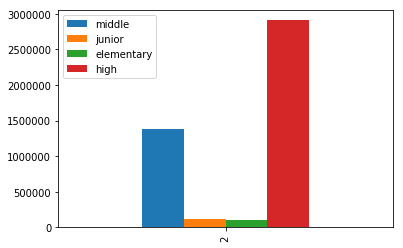

In [3]:
des = pd.read_csv(os.getcwd() + '/data/school_database.csv')

# remove unnecesary columns 
des = des[[c for c in des.columns if 'Unnamed' not in c]]

# identify school types 
des['public'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Pp]ublic[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)
des['middle'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Mm]iddle[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)
des['junior'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Jj]unior', d.split(',')[0])) else 0)
des['elementary'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Ee]lementary[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)
des['high'] = des['school_description'].apply(lambda d: 1 if len(re.findall('(?<!unior) [Hh]igh[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)

# gender distribution 
des['male'] = des['gender'].apply(lambda s: int(re.findall(r'([0-9]*) Male', str(s))[0]) if len(re.findall(r'([0-9]*) Male', str(s)))>0 else np.NaN)
des['female'] = des['gender'].apply(lambda s: int(re.findall(r'([0-9]*) Female', str(s))[0]) if len(re.findall(r'([0-9]*) Male', str(s)))>0 else np.NaN)

# students enrolled 
des['student'] = des['student'].apply(lambda s: re.findall(r'[0-9]*', str(s).replace(',',''))[0] if len(re.findall(r'[0-9]*',str(s)))>0 else np.NaN)
des['student'] = pd.to_numeric(des['student'], errors='coerce')

lvl_dist = pd.merge(data[['Rating','School']],
                    des[['School','middle','junior','elementary','high']],
                    on = 'School', 
                    how = 'outer',
                    indicator = True) 

dist = lvl_dist.groupby('_merge', as_index = False)[['middle','junior','elementary','high']].sum()
dist = dist[dist['_merge'] == 'both'].drop('_merge', 1)
dist.plot.bar()

### Creating Categorical Labels 

Above we saw that there is some consistency in the data. Now we will process the likert scale data submitted by reviewers. The characteristics rated are listed below. In this first block we check how the data is present by year. As can be seen in the table, only `Clarity`, `Easiness`, and `Helpfulness` are present in every year of the data. ` Knowledge` is available from 2011, `Exam Difficulty` and `Textbook Use` are present from 2013, and the rest are available starting 2015. 

In [15]:
# Create dummy variables for year to illustrate data availability over time 
data=pd.concat([data,
                pd.get_dummies(data['DateTime'].apply(lambda x: x.split('-')[0]),
                               prefix='Year')],
                axis = 1)

characteristics = ['Clarity',
                   'Easiness',
                   'Exam Difficulty',
                   'Helpfulness',
                   'Knowledge',
                   'Textbook Use',
                   'Determination',
                   'Effective',
                   'Empathy',
                   'Homework',
                   'Integrity',
                   'Parent Relation',
                   'Respect']

# Show the availability of variables across years 
yvars = [c for c in data.columns if 'Year_' in c]
corrs = data[characteristics + yvars].corr()
corrs.loc[characteristics, yvars]

,Year_2001,Year_2002,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018
Clarity,0.000527,0.001016,0.006069,-0.008172,-0.004438,-0.008973,-0.008382,-0.009673,0.001600,0.041908,0.023779,0.004017,-0.003509,0.001357,-0.021754,-0.013722,-0.016546,-0.004719
Easiness,-0.013498,-0.003028,-0.001202,-0.013927,-0.015329,-0.015031,-0.015084,-0.013463,0.037498,0.088910,0.058987,0.017889,-0.047095,-0.027665,-0.036051,-0.034220,-0.029205,-0.006071
Exam Difficulty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014538,0.010670,-0.003946,-0.000193,0.000283,0.001059
Helpfulness,-0.001440,-0.000578,-0.001631,-0.015709,-0.009532,-0.012074,-0.011983,-0.014139,0.000373,0.040003,0.024262,0.006052,-0.000961,0.008771,-0.009562,0.003273,-0.001053,-0.002187
Knowledge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013741,0.010849,-0.004940,0.017439,-0.019090,-0.003748,-0.010738,-0.004327
Textbook Use,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031407,0.059667,0.003305,-0.022251,-0.036976,-0.007009
Determination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001733,0.052486,-0.050895,-0.010435
Effective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002596,0.055320,-0.054122,-0.010677
Empathy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001939,0.054898,-0.053200,-0.011403
Homework,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003382,0.034523,-0.034457,-0.007902


Given the above distributions it may be intuitive that some variables are less frequent and more imbalanced than others. In the last block we remap some of the variable values to provide labels sufficient observations for training later. 

In [18]:
# we remap the middle values for exam difficulty and knowledge 
chart = {} 
chart['Exam Difficulty'] = {}
chart['Exam Difficulty'][2] = 1
data['Exam Difficulty']

chart['Knowledge'] = {}
chart['Knowledge'][2] = 1
chart['Knowledge'][4] = 3

# we remap all non-5 values for the remaining, low frequency characteristics 
fullmaps = ['Determination','Effective','Empathy','Homework','Integrity','Parent Relation','Respect']
for c in fullmaps: 
    chart[c] = {}
    chart[c][1] = 1
    chart[c][2] = 1
    chart[c][3] = 1
    chart[c][4] = 1
    data[c] = data[c].replace(chart[c])
    
# create an index for each of the attributes and store it in a dictionary
label_dict = {} 
for c in characteristics: 
    label_dict[c] = {}
    vals = list(data[data[c].notnull()][c].unique())
    val = vals[0]
    for val in vals:
        label_dict[c][val] = list(data.loc[data[c]==val].index)

# we save these indices so we can label the data clearly later on
bn.compressed_pickle(os.getcwd()+'/data/labeled_indices',label_dict)    

for c in characteristics:    
    print(data[c].value_counts())
    print('\n')

5.0    2985925
4.0     784586
3.0     469103
1.0     348436
2.0     273265
Name: Clarity, dtype: int64


5.0    1914717
3.0    1169729
4.0     949123
2.0     521333
1.0     307276
Name: Easiness, dtype: int64


3.0    213756
5.0    158176
4.0    147273
1.0    108101
2.0     87353
Name: Exam Difficulty, dtype: int64


5.0    3147716
4.0     657923
3.0     417740
1.0     369453
2.0     268904
Name: Helpfulness, dtype: int64


5.0    790414
4.0    122363
3.0     61162
1.0     58304
2.0     33487
Name: Knowledge, dtype: int64


1.0    209921
5.0    193305
3.0    129412
4.0     94555
2.0     85917
Name: Textbook Use, dtype: int64


5.0    13612
1.0     8685
Name: Determination, dtype: int64


5.0    14048
1.0     8249
Name: Effective, dtype: int64


5.0    13728
1.0     8569
Name: Empathy, dtype: int64


5.0    11901
1.0    10396
Name: Homework, dtype: int64


5.0    14037
1.0     8260
Name: Integrity, dtype: int64


5.0    14043
1.0     8254
Name: Parent Relation, dtype: int64


5.0    139